In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf # type: ignore
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.metrics import AUC

In [2]:
df = pd.read_parquet('train.parquet')

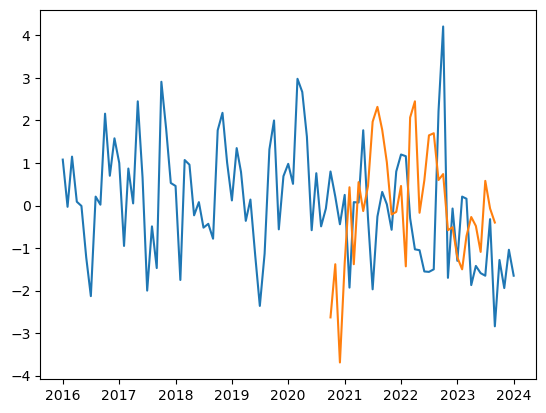

In [5]:
plt.plot(df["dates"][30], df['values'][30])
plt.plot(df["dates"][37], df['values'][37])


In [ ]:
# get the longest time interval
all_period = df['dates'][30]
len(all_period)

In [ ]:
# for all time periods for which data is missing set value to 0
correct_data = []
for i in range(80000):
    start = df['dates'].iloc[i][0]
    for j in range(len(all_period)):
        if all_period[j] == start:
            correct_data.append(pd.Series(np.concatenate((np.zeros(j) , df["values"].iloc[i] , np.zeros(97-j-len(df['dates'].iloc[i]))))))

In [8]:
df['correct_values'] = correct_data

In [ ]:
# dataset has missing values

missing_indices = df.index[df['correct_values'].apply(lambda x: np.isnan(x).any())].tolist()
missing_indices

In [ ]:
# delete missing values

df = df[~df['correct_values'].apply(lambda x: np.isnan(x).any())]
df

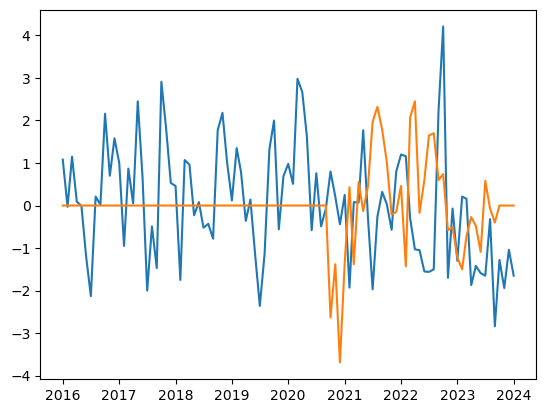

In [12]:
plt.plot(all_period, df['correct_values'][30])
plt.plot(all_period, df['correct_values'][37])

In [13]:
data = pd.DataFrame(df['correct_values'])
data

,correct_values
0,0 -1.86 1 0.79 2 1.40 3 0.15 4 ...
1,0 0.00 1 0.00 2 0.00 3 0.00 4 ...
2,0 0.0 1 0.0 2 0.0 3 0.0 4 ...
3,0 -0.33 1 0.58 2 1.10 3 -0.56 4 ...
4,0 1.31 1 0.50 2 -0.54 3 0.95 4 ...
...,...
79995,0 0.0 1 0.0 2 0.0 3 0.0 4 ...
79996,0 0.0 1 0.0 2 0.0 3 0.0 4 ...
79997,0 0.00 1 0.00 2 -0.78 3 -2.27 4 ...
79998,0 0.00 1 -2.29 2 -2.85 3 0.92 4 ...


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, df['label'])

In [17]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(97, 1)))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
adam = Adam(learning_rate=0.001)
chk = ModelCheckpoint("model2.keras", monitor='val_auc', save_best_only=True, mode='max', verbose=1)
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=[AUC()])

In [ ]:
X_train = np.array(X_train['correct_values'])
for i in range(len(X_train)):
    X_train[i] = np.array(X_train[i])
y_train = np.array(y_train)

X_train = np.stack(X_train)

In [21]:
model2.fit(X_train, y_train, epochs=50, batch_size=128, callbacks=[chk], validation_split=0.2)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - auc: 0.7502 - loss: 0.5118
Epoch 1: val_auc improved from -inf to 0.84205, saving model to model2.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 50s 129ms/step - auc: 0.7503 - loss: 0.5117 - val_auc: 0.8420 - val_loss: 0.4408
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - auc: 0.8487 - loss: 0.4127
Epoch 2: val_auc improved from 0.84205 to 0.86621, saving model to model2.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - auc: 0.8487 - loss: 0.4127 - val_auc: 0.8662 - val_loss: 0.3897
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - auc: 0.8763 - loss: 0.3765
Epoch 3: val_auc did not improve from 0.86621
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - auc: 0.8763 - loss: 0.3765 - val_auc: 0.8581 - val_loss: 0.4342
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - auc: 0.8817 - loss: 0.3688
Epoch 4: val_auc improved from 0.86621 to 0.88679, saving model to model2.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - auc: 0.88

In [ ]:
X_test = np.array(X_test['correct_values'])
for i in range(len(X_test)):
    X_test[i] = np.array(X_test[i])
y_test = np.array(y_test)

Evaluating the model

In [ ]:
X_test = np.stack(X_test)

In [ ]:
model = load_model("model2.keras")

In [30]:
y_pred = model.predict(X_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


In [34]:
auc = roc_auc_score(y_test, y_pred)
auc

0.9173694585804248

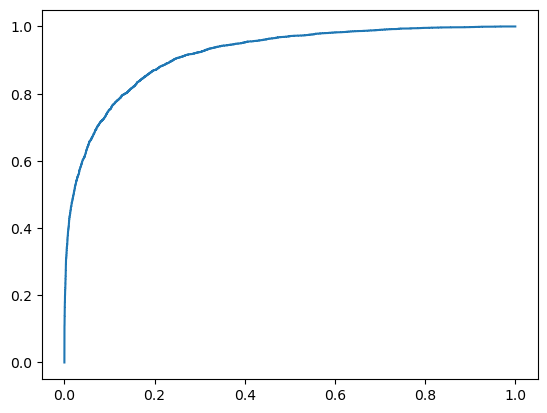

In [37]:
curve = roc_curve(y_test, y_pred)
plt.plot(curve[0], curve[1])